In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data_utils


# Our libraries
from trainMulti import train_model
import imageFolderMulti
from model_utils import *
from predict_utilsMulti import *
from vis_utilsMulti import *
from apmeter import *
from train_valid_split import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

use_gpu = True
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if (cuda_available and use_gpu) else "cpu")

In [2]:
def plot_loss(trn_hist, val_hist, loss_acc):
    plt.plot(trn_hist, label='Training ' + loss_acc)
    plt.plot(val_hist, label='Validation ' + loss_acc)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(loss_acc)
    plt.show()

In [3]:
def freeze_bn(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [5]:
class ThreeInputsNetAverage(nn.Module):
    def __init__(self, model1, model2, model3):
        super(ThreeInputsNetAverage, self).__init__()

        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        
        self.cf1 = nn.Parameter(torch.ones(1,1))
        self.cf2 = nn.Parameter(torch.ones(1,1))
        self.cf3 = nn.Parameter(torch.ones(1,1))

    def forward(self, input1, input2, input3):
        out1 = self.model1(input1)
        out2 = self.model2(input2)
        out3 = self.model3(input3)
        
        #cf1 = 1.5/5
        #cf2 = 2.5/5
        #cf3 = 1/5
        
        out1 = out1.mul(self.cf1)
        out2 = out2.mul(self.cf2)
        out3 = out3.mul(self.cf3)
        
        combined = out1.add(out2).add(out3)
        out = combined
        return out

In [6]:
class ThreeInputsNetConcat(nn.Module):
    def __init__(self, model1, model2, model3):
        super(ThreeInputsNetConcat, self).__init__()

        model1_modules = list(model1.children())[:-1]
        self.model1 = nn.Sequential(*model1_modules)
        model2_modules = list(model2.children())[:-1]
        self.model2 = nn.Sequential(*model2_modules)
        model3_modules = list(model3.children())[:-1]
        self.model3 = nn.Sequential(*model3_modules)
        
        self.model1.add_module('flatten', Flatten())
        self.model2.add_module('flatten', Flatten())
        self.model3.add_module('flatten', Flatten())
        
        num_ftrs1 = model1.fc.in_features
        num_ftrs2 = model2.fc.in_features
        num_ftrs3 = model3.fc.in_features
        num_classes = model1.fc.out_features
        self.fc1 = nn.Linear(num_ftrs1 + num_ftrs2 + num_ftrs3, num_ftrs1)
        self.fc2 = nn.Linear(num_ftrs1, num_classes)

    def forward(self, input1, input2, input3):
        x1 = self.model1(input1)
        x2 = self.model2(input2)
        x3 = self.model3(input3)
        
        x = torch.cat((x1, x2, x3), dim=1)
        #print(x.size())
        x = self.fc1(x)
        x = nn.ReLU()(x)
        out = self.fc2(x)
        
        return out

In [7]:
DATA_DIR_P = "F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/mask_pose/"
DATA_DIR_T = "F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/im2flow/"
DATA_DIR_S = "F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/willow_PNG/"


sz = 224
batch_size = 4

trn_dir_P = f'{DATA_DIR_P}train'
val_dir_P = f'{DATA_DIR_P}valid'
test_dir_P = f'{DATA_DIR_P}test'

trn_dir_S = f'{DATA_DIR_S}train'
val_dir_S = f'{DATA_DIR_S}valid'
test_dir_S = f'{DATA_DIR_S}test'

trn_dir_T = f'{DATA_DIR_T}train'
val_dir_T = f'{DATA_DIR_T}valid'
test_dir_T = f'{DATA_DIR_T}test'


trn_fnames_P = glob.glob(f'{trn_dir_P}/*/*.png')
train_ds_P = datasets.ImageFolder(trn_dir_P)
train_ds_P.class_to_idx

trn_fnames_S = glob.glob(f'{trn_dir_S}/*/*.png')
train_ds_S = datasets.ImageFolder(trn_dir_S)

trn_fnames_T = glob.glob(f'{trn_dir_T}/*/*.png')
train_ds_T = datasets.ImageFolder(trn_dir_T)


In [21]:
## Data ugmentation


# Data augmentation and normalization for training 
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_ds = imageFolderMulti.ImageFolder([trn_dir_P,trn_dir_S,trn_dir_T], train_transforms)
valid_ds = imageFolderMulti.ImageFolder([val_dir_P,val_dir_S,val_dir_T], valid_transforms)

train_ds, valid_ds = train_valid_split(train_ds, 10)


train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=4)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))


test_ds = imageFolderMulti.ImageFolder([test_dir_P,test_dir_S,test_dir_T], valid_transforms)
#test_ds = datasets.ImageFolder(test_dir_S,valid_transforms)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size= batch_size, num_workers=8)
class_names = train_ds_P.classes

Train size: 387
Valid size: 42 (0.10)


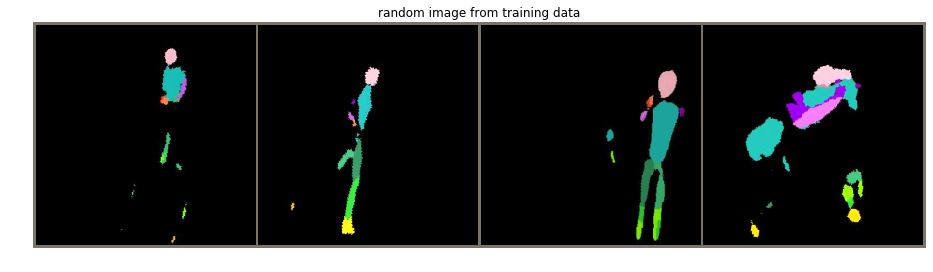

In [9]:
inputs, target =  next(iter(train_dl))
#out = torchvision.utils.make_grid(inputs, padding=3)
out = torchvision.utils.make_grid(inputs[0], padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='random image from training data')

In [10]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

fuse_method = 'average'

# load pre-trained ResNet50
model1 = load_pretrained_resnet50(model_path='models_willow/resnet50-pose-epoch-20-loss-1.20052.pth', num_classes=7)
model2 = load_pretrained_resnet50(model_path='models_willow/resnet50-spatial-epoch-7-loss-0.29937.pth', num_classes=7)
model3 = load_pretrained_resnet50(model_path='models_willow/resnet50-temporal-epoch-100-loss-1.52877.pth', num_classes=7)

if fuse_method == 'average':

    for param in model1.parameters():
        param.require_grad = False
    model1.fc.require_grad = True
    for param in model2.parameters():
        param.require_grad = False
    model2.fc.require_grad = True
    for param in model3.parameters():
        param.require_grad = False
    model3.fc.require_grad = True
    
    model = ThreeInputsNetAverage(model1, model2, model3)
    model.apply(freeze_bn)
    model.cf1.require_grad = True
    model.cf2.require_grad = True
    model.cf3.require_grad = True
    
else:

    for param in model1.parameters():
        param.require_grad = False
    model1.fc.require_grad = True
    for param in model2.parameters():
        param.require_grad = False
    model2.fc.require_grad = True
    for param in model3.parameters():
        param.require_grad = False
    model3.fc.require_grad = True
    
    model = ThreeInputsNetConcat(model1, model2, model3)
    model.apply(freeze_bn)


# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0002)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)

model = model.to(device)
criterion = criterion.to(device)

model

ThreeInputsNetAverage(
  (model1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
       

In [11]:
# training
    
model, trn_loss_hist, val_loss_hist, trn_acc_hist, val_acc_hist = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------
  train Loss: 0.55423 Acc: 0.82284
  valid Loss: 0.32728 Acc: 0.87879

Epoch 2/20
----------
  train Loss: 0.40804 Acc: 0.87413
  valid Loss: 0.38982 Acc: 0.89899

Epoch 3/20
----------
  train Loss: 0.41012 Acc: 0.85548
  valid Loss: 0.35366 Acc: 0.89899

Epoch 4/20
----------
  train Loss: 0.34446 Acc: 0.87879
  valid Loss: 0.39910 Acc: 0.86869

Epoch 5/20
----------
  train Loss: 0.30748 Acc: 0.91142
  valid Loss: 0.38341 Acc: 0.88889

Epoch 6/20
----------
  train Loss: 0.27765 Acc: 0.91841
  valid Loss: 0.36563 Acc: 0.88889

Epoch 7/20
----------
  train Loss: 0.24715 Acc: 0.92541
  valid Loss: 0.34686 Acc: 0.90909

Epoch 8/20
----------
  train Loss: 0.33435 Acc: 0.89744
  valid Loss: 0.37811 Acc: 0.88889

Epoch 9/20
----------
  train Loss: 0.30808 Acc: 0.91142
  valid Loss: 0.37679 Acc: 0.89899

Epoch 10/20
----------
  train Loss: 0.24456 Acc: 0.93473
  valid Loss: 0.32655 Acc: 0.89899

Epoch 11/20
----------
  train Loss: 0.27595 Acc: 0.91142
  valid Los

In [ ]:
loss_acc = 'Loss'
plot_loss(trn_loss_hist, val_loss_hist, loss_acc)

In [ ]:
loss_acc = 'Accuracy'
plot_loss(trn_acc_hist, val_acc_hist, loss_acc)

In [ ]:
for param in model.parameters():
    param.require_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
model, trn_loss_hist1, val_loss_hist1, trn_acc_hist1, val_acc_hist1 = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=30)

In [ ]:
trn_loss_hist.extend(trn_loss_hist1)
val_loss_hist.extend(val_loss_hist1)
trn_acc_hist.extend(trn_acc_hist1)
val_acc_hist.extend(val_acc_hist1)

In [ ]:
loss_acc = 'Loss'
plot_loss(trn_loss_hist, val_loss_hist, loss_acc)

In [ ]:
loss_acc = 'Accuracy'
plot_loss(trn_acc_hist, val_acc_hist, loss_acc)

In [17]:
# acuracy on validation data

def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        for i, inp in enumerate(inputs):
            inputs[i] = to_var(inputs[i], True)
        targets = to_var(targets, True)
        outputs = model(inputs[0],inputs[1],inputs[2])
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()

    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [15]:
# mAP
m = torch.nn.Softmax(dim=1)
def calculate_model_mAP(model, dataloader):
    mAP = APMeter()
    model.eval()  # for batch normalization layers
    for inputs, targets in dataloader:
        for i, inp in enumerate(inputs):
            inputs[i] = to_var(inputs[i], True)
        targets = to_var(targets, True)
        outputs = model(inputs[0],inputs[1],inputs[2])
        outputs = m(outputs)
        targets.resize_(targets.size(0), 1)
        
        one_hot = torch.cuda.FloatTensor(targets.size(0), outputs.size(1)).zero_()
        one_hot.scatter_(1, targets.data, 1)
        mAP.add(outputs,one_hot)
        #print(outputs.data)
    
    for i, value in enumerate(mAP.value()):
        print(train_ds.classes[i], ' AP: {:.2f}'.format(100. * value))
    print('mAP: {:.2f}'.format(100. * mAP.value().sum() / mAP.value().size(0)))

In [ ]:
evaluate_model(model, valid_dl)

In [ ]:
evaluate_model(model, train_dl)

In [ ]:
visualize_model(model, train_dl)

In [ ]:
plot_errors(model, train_dl)

In [ ]:
visualize_model(model, valid_dl, num_images=6)

In [ ]:
plot_errors(model, valid_dl)

In [ ]:
pred_class_names, y = predict_class_names(model, test_dl, class_names)

test_fnames= glob.glob(f'{test_dir_T}/*/*.png')
len(test_fnames), test_fnames [:5]

In [ ]:
test_fnames_len= len(test_fnames)
for i in range(test_fnames_len):
    test_fnames[i] = os.path.basename(test_fnames[i])
    
    len(test_fnames)
    
pred_result = np.stack([test_fnames, pred_class_names], axis=1)
len(pred_result), pred_result    

In [18]:
evaluate_model(model, test_dl)

accuracy: 85.00


In [16]:
calculate_model_mAP(model, test_dl)

InteractingWithComputer  AP: 93.70
Photographing  AP: 84.21
PlayingMusic  AP: 96.60
RidingBike  AP: 99.82
RidingHorse  AP: 99.94
Running  AP: 77.33
Walking  AP: 80.46
mAP: 90.29


In [ ]:
plot_errors(model, test_dl)

In [ ]:
# confusion matrix
y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(12,12 ))

In [ ]:
# confusion matrix
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(12,12 ))